# EOF analysis 

First of all, an acknowdlegment: I have borrowed *very* heavily for this lesson from the excellent material of Karen Smith, 
found here: https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/

I also recommend her book for background reading on the FFT and regression analysis that we covered.



### First, a few notes on terminology:

- EOF stands for Empirical Orthogonal Functions

- PCA stands for Principal Component Analysis

- EOF analysis and PCA are practically the same thing

- PCA is the more generally used term, and just implies converting a matrix into sets of linearly uncorrelated variables, called principle components.

- EOF analysis normally refers to finding the principle components that maximize the variance explained (i.e., a subset of all PC’s)

Say we have a data matrix $X$ which is a function of time and space $X[t,s]$, for now, let the rows denote different times and the columns different spatial locations (although this is not required for the actual application).
 In use, we often apply the technique to 2D data often, that is a function of x and y, i.e. $X=X[t,lon,lat]$, but that is essentially the same; just imagine taking all the lat/lon points and lining them up in a huge, long vector!

The goal of EOF analysis is to decompose $X$ into a set of spatial patterns, i.e, *orthogonal* eigenvectors, $e_i$’s, that explain the most variance of $X$. In other words, we want to maximize the resemblance of $e_i$ (which has dimention of $nlon*nlat$ spatial dimension) to the data, that is, find the $e_1$ vector that explains the most variance.

The figure provides a visualization of what we are trying to accomplish. $X$ is a data matrix consisting of sea-level pressure (SLP) in mb at 
 $N$ points in space and 
 $M$ points in time.

![EOF](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/_images/eofs.png)

The first eigenvector $e_1$ shows the pattern that explains the most variance in $X$. Note that just like the unit eigenvectors of 2-D or 3-D space, where $e_1=(1,0)$ or $(-1,0)$ are legitimate eigenvectors, the $e_1$
 describing the variance of $X$ can look like the pattern in the Figure or it can look like -1 x this pattern. I.e. PCA analysis produces an arbitrary sign in the patterns.

# Maximizing the resemblance of $e_1$ onto X = Eigenanalysis of C!

The resemblance of $e_1$ the to the data, $X$, is measured by the inner product of 
 $e_1$ with $X$ (this is also called the projection of $e_1$
 onto $X$).

If we want to maximize this resemblance, there are a few steps that we should take:

- we should square the resemblance to ensure that positive and negative resemblances are counted the same (as in the case of linear regression where we square the errors).


- we should normalize the eigenvector, $e_1$ to have unit length to make the resemblance independent of the magnitude of 
$e_1$.


If one follows these rules, the resemblance of 
 to the data turns out to be:

 $$(Xe_1)^2 = e_1^T X^T X e_1$$

If $e_1$ is a unit vector then the aim of finding the e_1 with the maximum variance  is the same as the task of maximizing 

$$ e_1^T C e_1$$

If that maximum resemblance equals $\lambda_1$
then we can write 

$$ e_1^T C e_1=\lambda_1$$

which we recognise straight away as an eigenvalue problem, as it can written 

$$ e e_1^T C e_1= e\lambda_1$$

thus

$$C e_1=\lambda_1 e_1$$

Thus $e_1$ must be an eigenvector of $C$ with corresponding eigenvalue $\lambda_1$. Hence, we can find 
 by “eigenanalyzing” C.  


## Key Points:

- The 1st eigenvector corresponds to the vector that explains the most variance in $X$ and has the largest eigenvalue

- The 2nd eigenvector corresponds to the vector that explains the second most variance in $X$ and has the 2nd largest eigenvalue

- The eigenanalysis of the covariance matrix transforms C into a different coordinate system where the “new” matrix is diagonal (
).

- In this new coordinate space, all of the variance is along the diagonal since the different vectors are orthogonal. Thus, the fraction of variance explained by the j$^{th}$ eigenvector is the corresponding eigenvalue 
 divided by the sum of all of the eigenvalues, that is

$\lambda_j / \sum \lambda_i$
 

Typically, EOFs are ordered by their corresponding $\lambda_i$
, such that EOF 1 explains the largest variance (largest 
) and the last EOF (typically the 
th EOF) has the smallest.

No other linear combination of $n$ 
 predictors can explain a larger fraction of the variance than the first $n$
 EOF/PC’s!

Remember also that the patterns (EOFs) are orthogonal, i.e. their dot product is zero.

The principal component time series, Z, are equivalent to mapping X into the new vector space spanned by the eigenvectors. We can do this by performing a linear transformation of X.

![PC and EOF](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/_images/pc_ts.png)



Let's build up a EOF analysis by scratch... First we need these packages:

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
datadir="/Users/tompkins/DATA/era5/monthly/nc/"
file=datadir+"total_precip.nc"

#datadir="http://clima-dods.ictp.it/Users/tompkins/diploma/data/"
#file=datadir+"total_precip.nc"+"#mode=bytes"

ds = xr.open_dataset(file)
precip=ds["tp"]*24000
lat=ds["lat"]
lon=ds["lon"]

## Step 1: Remove the mean

It is typical to remove the sampling dimension mean, which is usually the time dimension. This will result in your principal component time series having a mean of zero. You may also want to remove the seasonal or diurnal cycle if this is not of interest to you.

It is less common to remove the spatial mean. For example, suppose you are interested in the gradients in temperature, not the full temperature field itself or you are interested in the “wavy” component of the field, so you might remove the zonal mean.

In [3]:
#  Calculate the time mean for each grid point (lon, lat).
precip_mean = precip.mean(dim='time')
precip_std = precip.std(dim='time')

#  Subtract the time mean from the original data.
precip_anom_real = (precip - precip_mean)


# Step 2: Standardizing the data (optional)

Sometimes, it is desirable to take the amplitude of the variability out of the data before doing EOF analysis. For example, you may want to do this if

your data is made of a combination of parameters with different units, and you don’t want the parameter with the biggest units to dominate the variance

if the variance of the data varies greatly in space (and this is not of interest to you)

In order to do this, you divide your anomaly data by its standard deviation as well (now your data is in units of 
). For the rainfall example, we will not standardize the data as we are interested in capturing the spatial the magnitude of the variability.

In [4]:
### if commented out you can try to include this 
# precip_anom_real/=precip_std

## Step 3: Weighting gridded data

If the data is gridded, you need to weight the data according to the grid box area. For example, if the data is on a rectangular grid on a sphere (like in our example), the size of the grid boxes decreases as you move from the equator to the poles. 

if you are calculating EOFs using the covariance matrix and you are analyzing the temporal covariance matrix (as here, and often the case) then we need to weigh by the $\sqrt{(cos(lat))}$, because the covariance matrix is $XX^T$.

Note that the resulting EOFs will look unphysical and have unphysical values, this will be remedied when we discuss how to present EOFs (see below).

In [5]:

# 1. Convert latitude to radians.  Use .to_numpy() to ensure a numpy array
# for the cosine calculation, in case lat is a dask array.
lat_rad = (ds['lat'] * np.pi / 180.0)

# 2. Calculate the cosine weight.  Use np.sqrt for the square root
cos_wgt = np.sqrt(np.cos(lat_rad))

# 3. Apply the weighting.  Xarray will automatically broadcast cos_wgt
#    to match the dimensions of da.  This is the key to avoiding loops.
precip_anom=precip_anom_real*cos_wgt


## Step 4: Convert 3D array to 2D matrix

The next step is to convert our 3D array into a 2D matrix, so that we can perform matrix operations, specifically so that we c

In [6]:
# 4. Reshape the data to (ntime, nlon*nlat)
# Get the dimensions *before* reshaping
# 2. Extract dimensions
ntime, nlat, nlon = precip_anom.sizes['time'], precip_anom.sizes['lat'], precip_anom.sizes['lon']
precip_reshape = precip_anom.values.reshape(ntime,nlon * nlat)
precip_anom = xr.DataArray(
            precip_reshape,
            dims=['time', 'space'],
            coords={'time': precip_anom.coords['time']}  # Keep time coord
        )


precip_anom.shape

(138, 347040)


## Step 5: Calculate the covariance matrix

Our data is now ready for us to calculate the covariance matrix. Remember that we are going to calculate the temporal covariance matrix due to the slow computation speed associated with calculating the spatial dispersion matrix.

In [7]:
# calculate the covariance matrix
C = np.cov(precip_anom)
print(C.shape)

(138, 138)


## Step 6: Perform eigenanalysis of the covariance matrix
The next step is the eigenanalysis. Note that because we are eigenanalyzing the temporal covariance matrix,
the  eigenvectors correspond to the **principal component time series** and we will calculate the spatial patterns, the EOFs, by performing a linear transformation.

In [8]:
# eigenanalyze C
# LAM=Lambda eigenvalues, 
# which give us the explained variance 
#
# E=eigenvectors, the Principle Components (PCs)...
LAM, E = np.linalg.eig(C)


Let's take a look at the shape of the eigenvectors, what do we expect?

In [9]:
E.shape

(138, 138)

The result is a square matrix, with the first axis representing time, and the second is the PC number.
Thus the first PC1 which will correspond to the first pattern, is stored in ``E[:,0]``

We can now extract that pattern by projecting the weighted data matrix onto the PC time series, as this is what was used to calculate the covariance matrix.

We can do this by taking the dot product of the original field and the pc1:

``np.dot(precip_anom.T,pc1)``

Thus any variable that covaries with the PC will end up with a signal in the resulting dot product field.

**NOTE** We could apply this dot product to any other field to note how it co-varies with the index, but first it is better to normalize the PC series, which we will return to later

In [10]:
# number of EOF we want to analyse:
neof=5 

# empty list 
eof_da=[]
pc_da=[]

for ieof in range(neof):
    # compute the 1st EOF
    # the EOFs are computed by projecting the data matrix onto the PC time series
    EOF  = np.reshape(np.dot(precip_anom.T,E[:,ieof]), (nlat,nlon)) 

# Create an xarray DataArray for the EOF pattern with lat/lon coordinates
    eof_da.append(xr.DataArray(
        EOF,
        coords={'lat': precip.coords['lat'], 'lon': precip.coords['lon']},
        dims=['lat', 'lon']))
    pc_da.append(xr.DataArray(E[:,ieof], coords={'time': precip.coords['time']}, dims=['time']))


Let’s plot the EOF and PC time series to see what they look like.

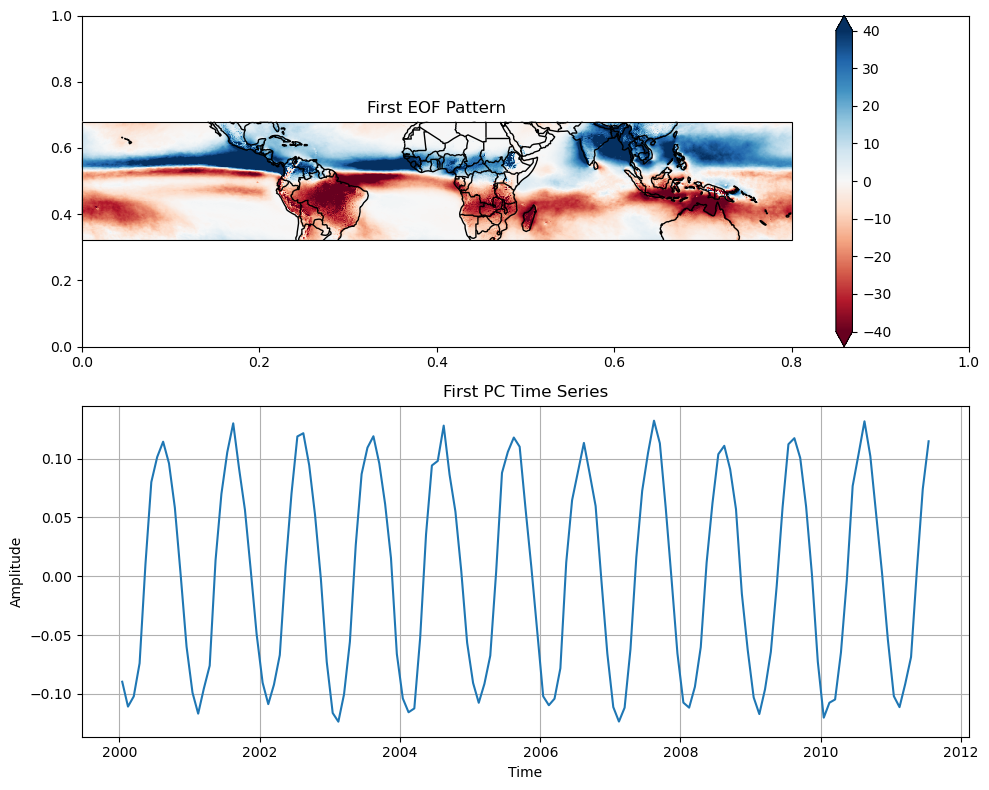

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8)) # removed  subplot_kw={'projection': ccrs.PlateCarree()}

# 11. Plot the first EOF pattern (top panel)
ax[0] = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree()) # added projection here
eof_da[0].plot(ax=ax[0], cmap='RdBu', transform=ccrs.PlateCarree(),vmin=-40, vmax=40)
ax[0].set_title('First EOF Pattern')
ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# 12. Plot the first PC time series (bottom panel)
pc_da[0].plot(ax=ax[1])
ax[1].set_title('First PC Time Series')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.savefig('/Users/tompkins/Downloads/eof_analysis_plot.jpg') #save the figure
plt.show()

## Presenting EOFs/PCs

The EOFs  and PC time series  that result from eigenanalysis of 
 are typically not in physical units. Recall that we have cosine-weighted our data and that the eigenvectors are unit vectors. Thus, there are a few post-processing steps that we need to go through in order to present our EOFs/PCs in a meaningful way.

Typically, we normalize the PC time series by dividing by its standard deviation. So, we simply need to standardize 
 to create an index.

We then project this normalized PC back onto the original anomaly data and divide by the length of 
 to get the EOF 1 structure in the original units i.e. the unweighted data.
 
Note that you can project  onto other variables as well. For example, in the case of the ENSO 3.4 index, we can project   onto the temperature or zonal wind onto the appropriate PC to see how these variables vary with ENSO.



In [12]:
pc_ts_std=[]
for pc in pc_da: 
   pc_ts_std.append((pc - np.mean(pc))/np.std(pc))


In [13]:
# convert the EOF into physical units

# first reshape original data from 3D to 2D
precip_reshape = precip_anom_real.values.reshape(ntime,nlon * nlat)

In [14]:
EOF_phys=[]

for pc in pc_ts_std: 
    EOF_phys1 = np.dot(pc.T,precip_reshape*(1/ntime))
    #reshape back for plotting
    EOF_phys1 = np.reshape(EOF_phys1,(nlat,nlon))

    EOF_phys.append(xr.DataArray(
        EOF_phys1,
        coords={'lat': precip.coords['lat'], 'lon': precip.coords['lon']},
        dims=['lat', 'lon'] ))


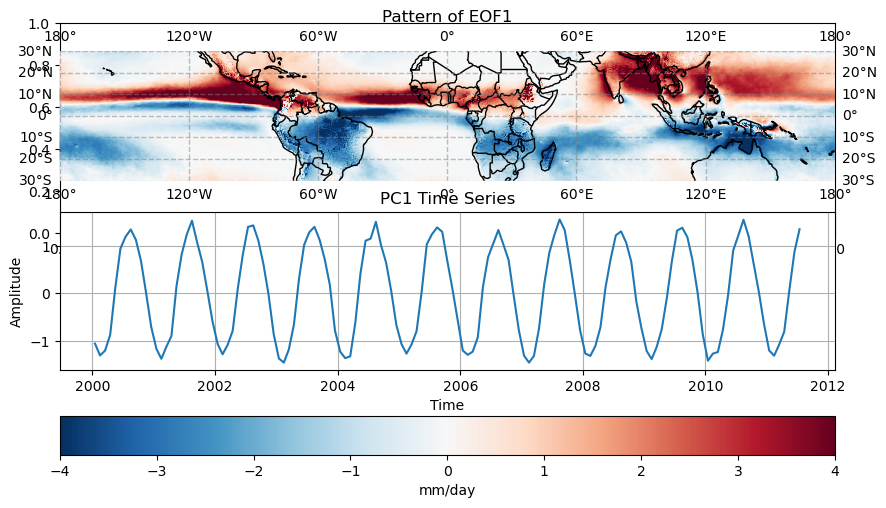

In [15]:
# Which eof do we want to plot (between 1 and neof)
peof=1  # peof=1 is the first EOF!!!

if peof>neof:
    print ("Bad plot eof, we only calculated neof=",neof, " resetting to EOF=1")
    peof=1


fig, ax = plt.subplots(2, 1, figsize=(10, 6)) # removed  subplot_kw={'projection': ccrs.PlateCarree()}


# 11. Plot the first EOF pattern (top panel)
ax[0] = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree()) # added projection here
im = EOF_phys[peof-1].plot(ax=ax[0], cmap='RdBu_r', transform=ccrs.PlateCarree(),vmin=-4,vmax=4,add_colorbar=False)
ax[0].set_title('Pattern of EOF'+str(peof))  # note peof=0 -> EOF1
ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS)
ax[0].xaxis.set_visible(False) # remove the original x axis
ax[0].yaxis.set_visible(False) # remove the original y axis
 

  # Add gridlines, labels, and ticks
gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

for spine in ax[0].spines.values():
    spine.set_visible(False)
# 12. Plot the first PC time series (bottom panel)
pc_ts_std[peof-1].plot(ax=ax[1])
ax[1].set_title('PC'+str(peof)+' Time Series')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

# Add a horizontal colorbar below the two subplots
fig.colorbar(im, ax=[ax[0], ax[1]], orientation='horizontal', pad=0.1, label='mm/day')

#plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.savefig('/Users/tompkins/Downloads/eof_analysis_plot.jpg') #save the figure
plt.show()

In [16]:
def create_eof_pc_animation(eof_pattern, pc_index, fps=10, filename="eof_animation.gif"):
    """
    Creates an animation of the EOF pattern and PC time series, with a moving marker
    on the time series plot.

    Args:
        eof_pattern (xarray.DataArray): The EOF pattern, with 'lat' and 'lon' coordinates.
        pc_index (xarray.DataArray): The PC time series.  Must have a 'time' dimension.
        fps (int, optional): Frames per second of the animation. Defaults to 10.
        filename (str, optional): Name of the output gif file. Defaults to "eof_animation.gif".

    Returns:
        matplotlib.animation.FuncAnimation: The animation object.
    """
    # Ensure eof_pattern has 'lat' and 'lon'
    if not ('lat' in eof_pattern.coords and 'lon' in eof_pattern.coords):
        raise ValueError("The EOF pattern must have 'lat' and 'lon' coordinates.")

    # Ensure pc_index has 'time'
    if 'time' not in pc_index.dims:
        raise ValueError("PC index must have a 'time' dimension.")

    ntime = pc_index.size
    time = pc_index.time

    fig, ax = plt.subplots(2, 1, figsize=(10, 6),
                           subplot_kw={'projection': ccrs.PlateCarree()})  #projection for map

    # ---  Set up initial plots (outside update function) ---
    # EOF Pattern (top panel)
    eof_plot = eof_pattern.plot(ax=ax[0], cmap='RdBu_r', transform=ccrs.PlateCarree(),
                                 vmin=-np.max(np.abs(eof_pattern)),
                                 vmax=np.max(np.abs(eof_pattern)),
                                 add_colorbar=False)
    ax[0].set_title('EOF Pattern')
    ax[0].coastlines()
    ax[0].add_feature(cfeature.BORDERS)
    ax[0].set_xticks([])  # Remove x-ticks
    ax[0].set_yticks([])  # Remove y-ticks
    for spine in ax[0].spines.values():
        spine.set_visible(False)

    # PC Time Series (bottom panel)
    pc_plot, = ax[1].plot(time, pc_index, 'b-')  # Line plot
    ax[1].set_title('PC Time Series')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Amplitude')
    ax[1].grid(True)
    time_marker, = ax[1].plot([], [], 'ro', markersize=8)  # Marker for current time

    # Colorbar (add once, outside update)
    fig.colorbar(eof_plot, ax=[ax[0], ax[1]], orientation='horizontal', pad=0.1,
                 label='Amplitude')  # same label as before

    # --- Update function for the animation ---
    def update(frame):
        """
        Update the plots for each frame of the animation.

        Args:
            frame (int): The frame number.
        """
        # Update EOF plot
        ax[0].cla()
        ax[0].coastlines()
        ax[0].add_feature(cfeature.BORDERS)
        ax[0].set_title(f'EOF Pattern, Time: {time.values[frame]}')
        eof_plot = eof_pattern * pc_index.values[frame]
        eof_im = eof_plot.plot(ax=ax[0], cmap='RdBu_r', transform=ccrs.PlateCarree(),
                                 vmin=-np.max(np.abs(eof_pattern)),
                                 vmax=np.max(np.abs(eof_pattern)),
                                 add_colorbar=False)

        ax[0].set_xticks([])  # Remove x-ticks
        ax[0].set_yticks([])  # Remove y-ticks
        for spine in ax[0].spines.values():
            spine.set_visible(False)

        # Update time marker position
        time_marker.set_data(time.values[frame], pc_index.values[frame])

        return  eof_im, time_marker,

    # --- Create and save the animation ---
    anim = FuncAnimation(fig, update, frames=ntime, interval=1000 / fps)
    writer = PillowWriter(fps=fps)
    anim.save(filename, writer=writer)
    print(f"Animation saved to {filename}")
    return anim

In [17]:
print(EOF_phys[0].coords)

Coordinates:
  * lat      (lat) float64 2kB -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8


In [18]:
### BUGGED, I need to correct

# 2. Call the function to create and save the animation
#animation = create_eof_pc_animation(pc_ts_std[0], EOF_phys[0], fps=15, filename="my_eof_animation.gif")

# 3. Display the animation in the notebook
#plt.show()  # important to call plt.show()

## How many EOFs/PCs are meaningful?

Eigenanalysis of the covariance matrix will always give you an answer. The orthogonality of the eigenvectors/EOFs imposes a constraint on their pattern. Higher order EOFs are often trying to represent the noise while still being orthogonal to the other EOFs and, consequently, these patterns can become spurious statistical constructs rather than physically meaningful modes of variability.

Add note on North here.



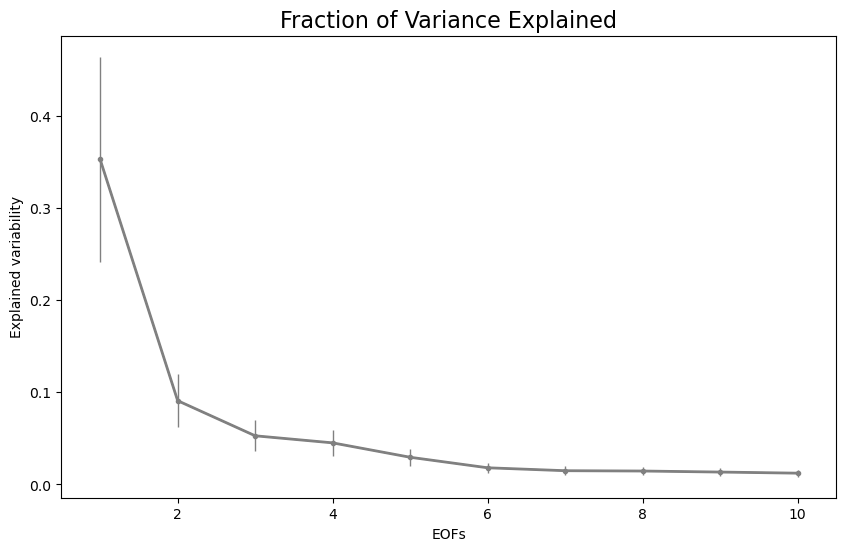

In [19]:
# set up plot
plt.figure(figsize=(10,6))

# plot fraction of variance explained by first 10 eigenvectors using the eigenvalues
plt.plot(np.arange(1,np.size(LAM[:10])+1.),LAM[:10] / LAM.sum(),'.-',color='gray',linewidth=2)
plt.xlim(0.5, 10.5)

# define N*
Nstar = len(pc_ts_std)

# compute error bars using the North et al. "rule of thumb"
eb = LAM[:10] / LAM.sum()*np.sqrt(2./float(Nstar))
plt.errorbar(np.arange(1,np.size(LAM[:10])+1.),LAM[:10] / LAM.sum(),yerr = eb/float(2), xerr = None, linewidth = 1, color = 'gray')

# add labels, title, etc.
plt.title('Fraction of Variance Explained',fontsize=16)
plt.xlabel('EOFs')
plt.ylabel('Explained variability')
plt.show()

## Multivariate EOF analysis 

We will not cover it here, but it is straightforward to extend this technique to multivariate EOF analysis, that is, analysis of spatial co-variability between fields.  An example of this is the use of VP200, OLR and winds together to define an index for the Madden Julian Oscillation (MJO), (REFERENCE HERE).  

Usually, in order to conduct a multivariate EOF analysis, of say, $nvar$ variables, the variables are lined up in a single vector in the spatial dimension, that is, the 2D matrix $X$ we analysis will have dimensions [ntime,nvar x nlon x nlat]. In practise, with multivariate EOF analysis it is necessary to normalize all variables to prevent the variable with the largest *absolute* values from dominating the variance. The scaling is reinserted when projecting the PCs back onto the original data as in the final steps above.

## Caveat on modes

A finally, a caveat!  While it is often apparent and tempting to conclude that the leading eigenvector(s) of variability is/are associated with natural modes of variability in the atmospheric system (it has been applied variously to seasonality, ENSO, MJO, PDO, NAO, AMOC,  etc...) one does have to make this jump with caution!  Recall that PCA is nothing more than a statistical technique and sometimes this association can be misleading.

In order to improve this, some people use rotated EOFs, where the coordinate system is rotated to maximize the variance in the leading modes.  A commonly used method is the [varimax method](https://online.stat.psu.edu/stat505/lesson/12/12.11). This can lead to simpler leading modes that might be easier to interpret, but at the cost of losing orthogonality in the PCs (and sometimes also the EOFs).  

**Further reading**: For more on this caveat, take a look at this [excellent paper by Dommenget and Latif (2002)](https://journals.ametsoc.org/view/journals/clim/15/2/1520-0442_2002_015_0216_acnoti_2.0.co_2.xml?alreadyAuthRedirecting) for further reading.



## Summary 

- **Covariance Matrix ($C$)**: In EOF/PCA, the covariance matrix $C$ represents the relationships between different spatial points (or variables) in your data. A high covariance between two points means they tend to vary together.

- **Eigenanalysis**: This is a mathematical technique applied to the covariance matrix. It involves finding the eigenvectors and eigenvalues of $C$.

- **Eigenvectors**: These are special vectors that, when multiplied by the matrix $C$, only change in magnitude, not direction. In EOF/PCA, the eigenvectors represent the spatial patterns (EOFs) of variability in your data.

- **Eigenvalues**: These are the factors by which the eigenvectors are scaled when multiplied by C. In EOF/PCA, the eigenvalues represent the amount of variance in the data explained by each corresponding EOF.

Eigenanalysis essentially *rotates the original coordinate system* (defined by your original spatial points) into a *new coordinate system* defined by the eigenvectors. In the new coordinate system, the covariance matrix becomes a diagonal matrix with non-zero values only on its main diagonal and zeros everywhere else.

Variance is along the diagonal: When the covariance matrix is diagonal, the values on the diagonal represent the variance of the data along each of the new axes (the eigenvectors). Because it's diagonal, there's no covariance between these new axes (they are orthogonal). This means the eigenvectors represent *independent patterns of variability*.



# Exercises

1) Examine a different field and see how the PCA analysis reveals something about dynamics. E.g. NAO (z500), individual monsoons (precip), IOD or ENSO (SST)

2) Investigate how to use CDO to calculate EOFs and PCs  - for this see the tips below...

3) 



## EOFs  in CDO (climate data analysis)

As jupyter notebooks can only run one kernal, i.e. choice between bash and python then I can only illustrate here the method without implementation (you can of course use the cdo wrapper in python)

So here we go:

First we remove the mean from the input:

``#!/bin bash``
``cdo sub input.nc -timmean input.nc anom.nc``

Now we perform the EOF analysis, we ask for the first 5 EOFs (you can choose of course):

``cdo eof,5 anom.nc eigval.nc pattern.nc``

Now we project the pattern onto the data to get the PCs, note that "pc" is a "stub", CDO outputs a single file per PC, and thus produces pc00001.nc pc00002.nc ...etc in this case etc (I've never understood why they don't output a single file with a pc dimention index).  

``cdo eofcoeff pattern.nc anom.nc pc``

This is how we get the explained variance, basically we use the eigenvalues divided by their sum.

``cdo -div eigval.nc -timsum eigval.nc explvar.nc``

You will notice that the EOF and PC magnitudes are not associated with sensible values (just as in the python example)
So we need to normalize the PC timeseries and project it back on the data to get the associated anomaly in field units.

Choose a PC:

``pc=pc00000.nc``

Normalize it 

``cdo div -sub $pc -timmean $pc -timstd $pc ${pc???}_std.nc``

Here in order to project it we need to calculate the covariance but that needs a file which is ntime,nlon,nlat, as CDO can not broadcast in space, only in time, so we use the enlarge function:

``cdo enlarge,precip_anom.nc  ${pc???}_std.nc ${pc???}_std_lg.nc``

And now we do the projection

``cdo timcovar precip_anom.nc ${pc???}_std_lg.nc precip_eof.nc``

And that's it!

